In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pwd

/content


In [7]:
%cd /content/drive/MyDrive/Study/NLP/밑딥2/deep-learning-from-scratch-2

/content/drive/MyDrive/Study/NLP/밑딥2/deep-learning-from-scratch-2


In [8]:
!ls

ch01  ch03  ch05  ch07	common	   dataset			LICENSE.md
ch02  ch04  ch06  ch08	cover.png  equations_and_figures_2.zip	README.md


# ch 04 : word2vec 속도 개선



1.   Embedding 계층 도입
2.   Negative Sampling ( Loss Function )



# 4.1 word2vec 개선 1 : Embedding Layer

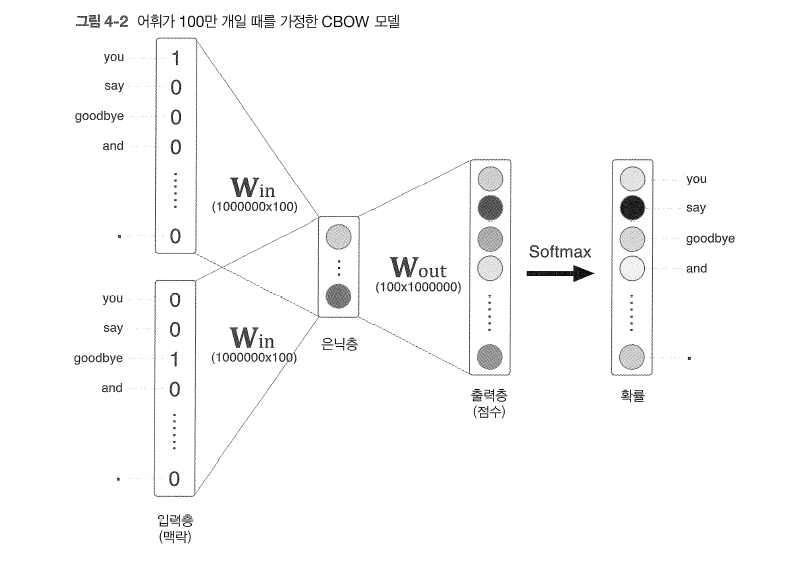

* 거대한 말뭉치를 다루게 될 경우의 word2 vec의 문제점 ( 병목 현상 발생 )
1. 입력층의 원핫 표현과 가중치 행렬 Win의 곱 계산 ( 4.1 절에서 해결 ) -> Emdedding 계층 도입
2. 은닉층과 가중치 행렬 Wout의 곱 및 Softmax 계층의 계산 ( 4.2 절에서 해결 ) -> Negative Sampling Loss function 도입

# 4.1.1 Embedding 계층

* Embedding 계층에 단어 임베딩( 분산 표현 )을 저장하는 것.

## 4.1.2 Embedding 계층 구현

In [ ]:
import numpy as np
W=np.arange(21).reshape(7,3)

W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [ ]:
W[2]

array([6, 7, 8])

In [ ]:
W[5]

array([15, 16, 17])

In [ ]:
idx=np.array([1,0,3,0])

W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

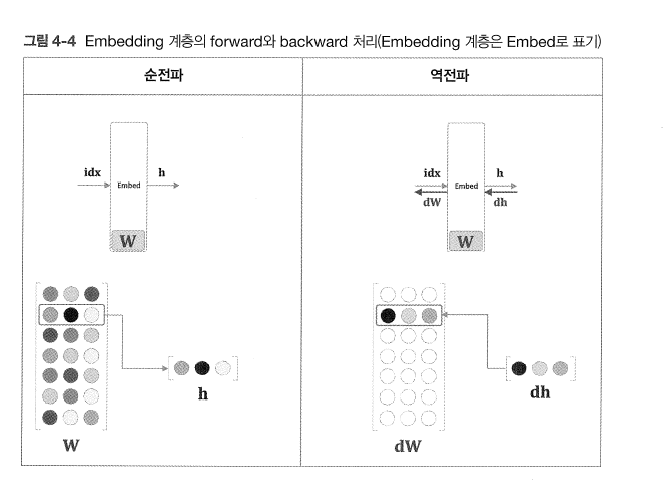

In [ ]:
class Embedding:
  def __init__(self,W):
    self.params=[W]
    self.grads=[np.zeros_like(W)]
    self.idx=None # idx : 추출할 행의 인덱스(단어ID)를 배열로 저장.

  def forward(self,idx):
    W,=self.params
    self.idx=idx
    out=W[idx]
    return out
  
  def backward(self,dout):
    dW,=self.grads
    dW[...]=0
    # dW[self.idx]=dout # 실은 나쁜 예
    for i, word_id in enumerate(self.idx): 
      dW[word_id] +=dout[i] # 추출 중복 인덱스 처리 ( 덧셈으로 처리해줌 )
    # 혹은
    # np.add.at(dW,self.idx,dout) # np.add.at(A,idx,B)는 B를 A의 idx 번쨰 행에 더해준다.

    return None

  

# 4.2 word2vec 개선 2 : Negative Sampling

* Negative Sampling을 사용하면 어휘가 아무리 많아져도 계산량을 낮은 수준에서 일정하게 억제할 수 있다.

## 4.2.1 은닉층 이후 계산의 문제점

* 은닉층의 뉴런과 가중치 행렬(Wout)의 곱
* Softmax 계층의 계산 

## 4.2.2 다중 분류에서 이진 분류로

* 다중 분류(multi-class) classfication을 '이진 분류'로 근사
* 출력 층의 가중치 Wout에서 각 단어 ID의 단어 벡터가 각각의 열로 저장되어 있는데, 모든 단어를 대상으로 계산을 수행하는 것이 아니라, 해당하는 단어벡터 (특정한 하나의 열)만을 추출해서 계산하는게 차이이다.

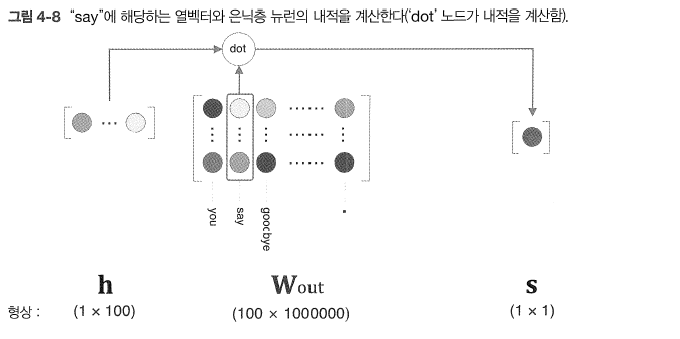

## 4.2.3 시그모이드 함수와 교차 엔트로피 오차

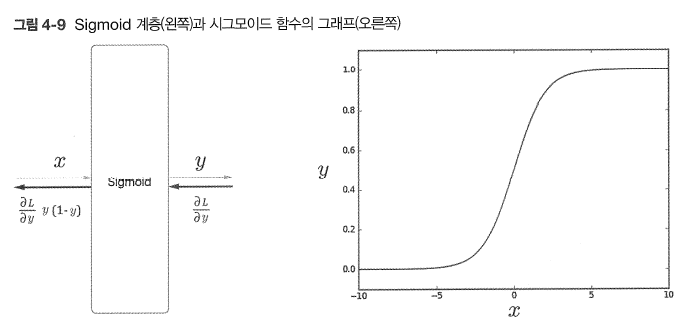

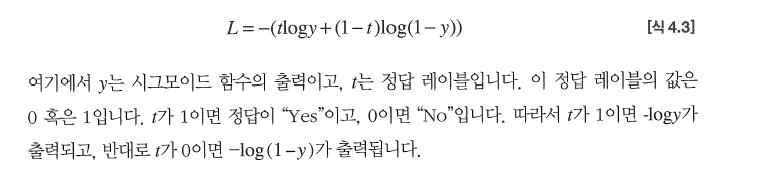

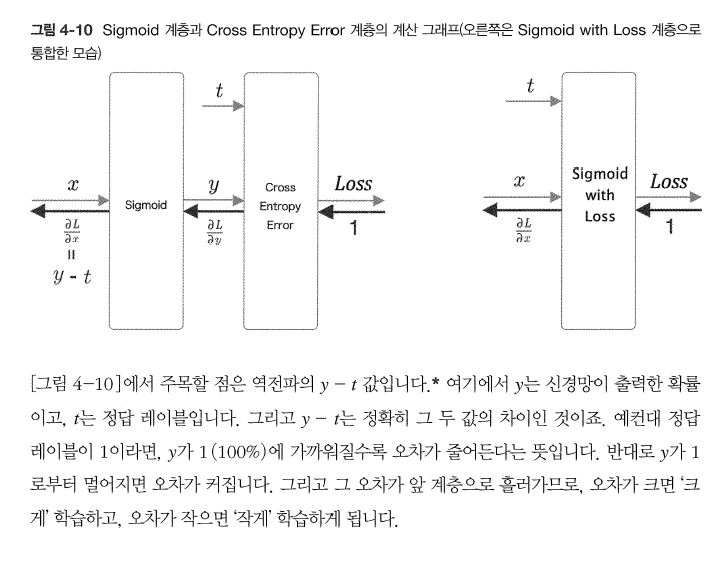

## 4.2.4 다중 분류에서 이진 분류로 (구현)

* Embedding 계층 : 대상 단어 ID의 분산 표현(단어 벡터)를 추출
* Sigmoid with Loss : 해당 단어가 답인지 아닌지를 1,0으로 표현

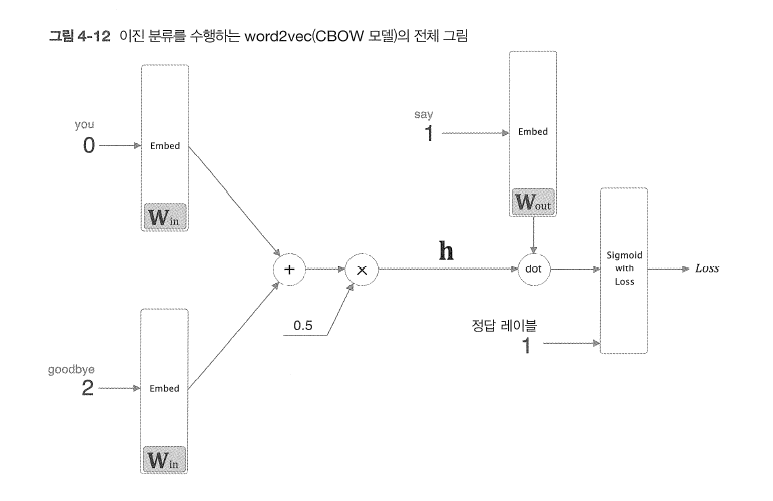

* 위의 출력층에서 은닉층 값과 정답 레이블의 내적 연산 + Embedding(추출) 을 Embedding Dot 계층으로 합쳐준다.

In [ ]:
class EmbeddingDot:
  def __init__(self,W):
    self.embed=Embedding(W) # Embdedding 계층 저장
    self.params=self.embed.params
    self.grads=self.embed.grads
    self.cache=None # 순전파 시의 계산 결과를 잠시 저장

  def forward(self,h,idx): # h : 은닉층 뉴런, idx = 단어 ID의 넘파이 배열, 미니배치 처리를 가정했으므로 배열형태이다.
    target_W=self.embed.forward(idx)
    out=np.sum(target_W*h,axis=1) # 내적 계산 : 원소별 곱셈 후 행 별 덧셈.

    self.cache=(h,target_W)
    return out

  def backward(self,dout):
    h,target_W=self.cache
    dout=dout.reshape(dout.shape[0],1) # Embedding backward idx

    dtarget_W=dout*h # ?
    self.embed.backward(dtarget_W) 
    dh=dout*target_W
    return dh

# 4.2.5 네거티브 샘플링

* 긍정적인 예( 정답 )에 대해선 1에 가까운 높은 확률을 출력하고, 부정적인 예 ( 오답 ) 에 대해선 0에 가까운 낮은 확률을 출력하도록 학습하는 방법. ( 적은 수의 부정적 예를 샘플링 해 사용한다. )

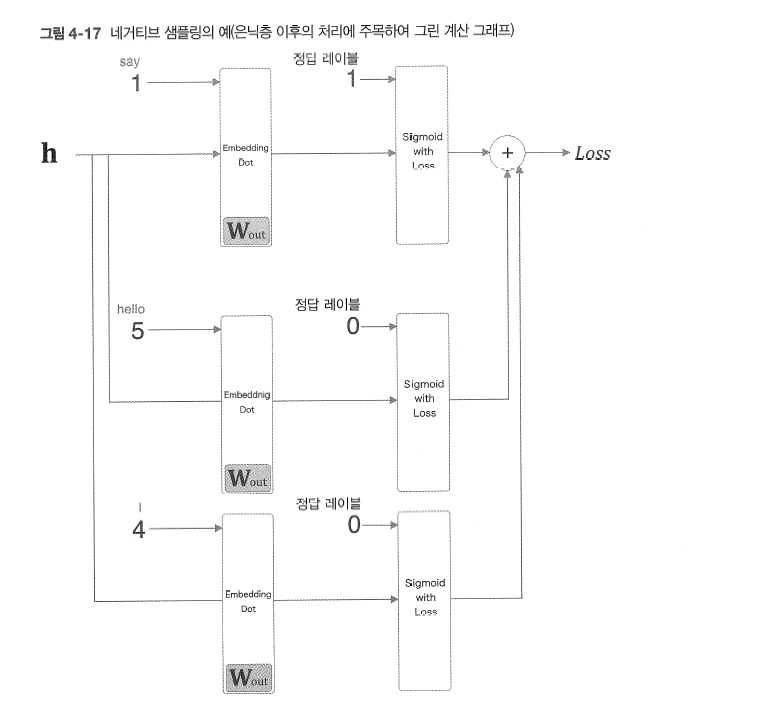

# 4.2.6 네거티브 샘플링의 샘플링 기법

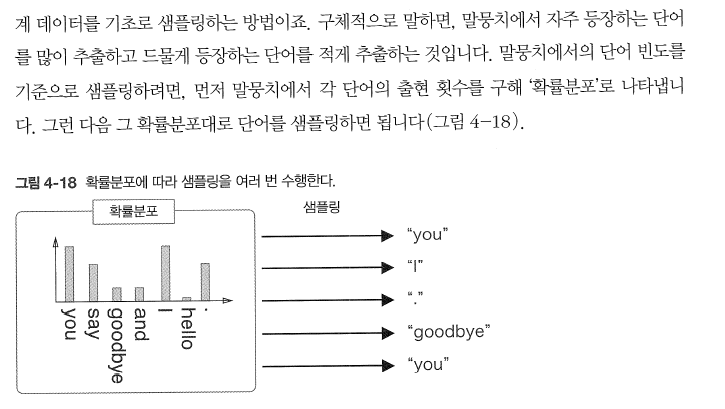

In [ ]:
import numpy as np

np.random.choice(10)

7

In [ ]:
np.random.choice(10)

1

In [ ]:
words=['you','say','goodbye','I','hello','.']
np.random.choice(words)


'.'

In [ ]:
np.random.choice(words,size=5) # 중복 있음

array(['hello', '.', '.', 'say', 'hello'], dtype='<U7')

In [ ]:
np.random.choice(words,size=5,replace=False) # 중복 없음

array(['you', '.', 'say', 'goodbye', 'hello'], dtype='<U7')

In [ ]:
p=[0.5,0.1,0.05,0.2,0.05,0.1] # p에 확률 분포를 담은 리스트를 지정하면, 그 확률 분포대로 샘플링한다.
np.random.choice(words,p=p)

'you'

In [ ]:
p=[0.7,0.29,0.01]
new_p=np.power(p,0.75) # 낮은 확률의 단어가 더 쉽게 샘플링되도록 조치 (권고 사항)
new_p/=np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [ ]:
!ls

ch01  ch03  ch05  ch07	common	   dataset			LICENSE.md
ch02  ch04  ch06  ch08	cover.png  equations_and_figures_2.zip	README.md


In [ ]:
from ch04.negative_sampling_layer import UnigramSampler
corpus=np.array([0,1,2,3,4,1,2,3])
power=0.75
sample_size=2

sampler=UnigramSampler(corpus,power,sample_size)
target=np.array([1,3,0])
negative_sample=sampler.get_negative_sample(target)
print(negative_sample)

[[4 3]
 [2 4]
 [2 3]]


# 4.2.7 네거티브 샘플링 구현

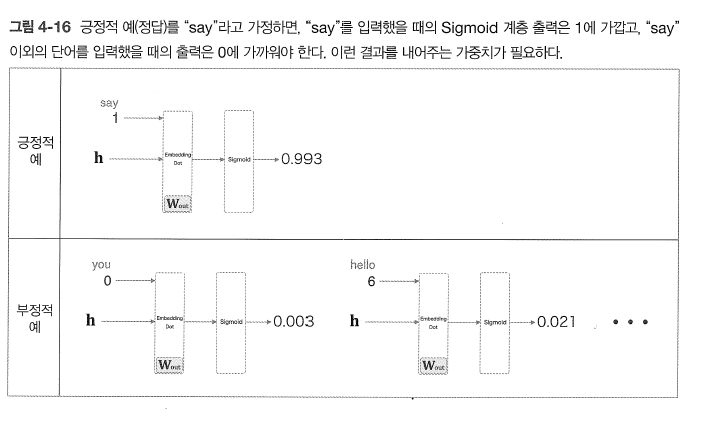

In [ ]:
class NegativeSamplingLoss:
  def __init__(self,W,corpus,power=0.75,sample_size=5):
    self.sample_size=sample_size
    self.sampler=UnigramSampler(corpus,power,sample_size)
    self.loss_layers=[SigmoidWithLoss() for _ in range(sample_size+1)] # 1(정답) + sample_size(오답)
    self.embed_dot_layers=[EmbeddingDot(W) for _ in range(sample_size+1)]
    self.params,self.grads=[],[]
    for layer in self.embed_dot_layers:
      self.params+=layer.params
      self.grads+=layer.grads

    def forward(self,h,target):
      batch_size=target.shape[0]
      negative_sample=self.sampler.get_negative_sample(target)
      
      # 긍정적 예 순전파
      score=self.embed_dot_layers[0].forward(h,target) # embedding -> 내적 후, 행별로 합 계산한 array
      correct_label=np.ones(batch_size,dtype=np.int32) # ??
      loss=self.loss_layers[0].forward(score,correct_label)

      # 부정적 예 순전파
      negative_label=np.zeros(batch_size,dtype=np.int32) # ??
      for i in range(self.sample_size):
        negative_target=negative_sample[:,i]
        score=self.embed_dot_layers[1+i].forward(h,negative_sample)
        loss+=self.loss_layers[1+i].forward(score,negative_label)
      return loss


    def backward(self,dout=1):
      dh=0
      for l0,l1 in zip(self.loss_layers,self.embed_dot_layers):
        dscore=l0.backward(dout)
        dh+=l1.backward(dscore)

      return dh
  

# 4.3 개선판 word2vec 학습

## 4.3.1 CBOW 모델 구현

In [9]:
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
  def __init__(self,vocab_size,hidden_size,window_size,corpus):
    V,H=vocab_size,hidden_size

    # 가중치 초기화
    W_in=0.01*np.random.randn(V,H).astype('f')
    W_out=0.01*np.random.randn(V,H).astype('f') # SimpleCBOW에서는 입력측의 가중치와 출력층의 가중치 형상이 달랐지만, NegativeSamplingLoss 클래스에서 Embedding 계층을 사용하므로, 여기선 같은 형상을 사용한다.

    # 계층 생성
    self.in_layers=[]
    for i in range(2* window_size): # 
      layer=Embedding(W_in) # Embedding 계층 사용
      self.in_layers.append(layer)
    self.ns_loss=NegativeSamplingLoss(W_out,corpus,power=0.75,sample_size=5)

    # 모든 가중치와 기울기를 배열에 모은다.
    layers=self.in_layers+[self.ns_loss]
    self.params,self.grads=[],[]
    for layer in layers:
      self.params+=layer.params
      self.grads+=layer.grads

    # 인스턴스 변수에 단어의 분산 표현을 저장한다.
    self.word_vecs=W_in

  def forward(self,contexts,target):
    h=0
    for i,layer in enumerate(self.in_layers):
      h+=layer.forward(contexts[:,i])
    h*=1/len(self.in_layers)
    loss=self.ns_loss.forward(h,target)
    return loss

  def backward(self,dout=1):
    dout=self.ns_loss.backward(dout)
    dout*=1/len(self.in_layers)
    for layer in self.in_layers:
      layer.backward(dout)
    return None
    

# 4.3.2 CBOW 모델 학습코드

In [3]:
!ls

sample_data


In [ ]:
from common import config
import numpy as np
# from common import config
# # GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# # ===============================================
# config.GPU = True
# # ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from ch04.skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 3[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 5[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 6[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 8[s] | 손실 3.77
| 에폭 1 |  반복 141 / 9295 | 시간 9[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 10[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 12[s] | 손실 3.37
| 에폭 1 |  반복 201 / 9295 | 시간 13[s] | 손실 3.25
| 에폭 1 |  반복 221 / 9295 | 시간 14[s] | 손실 3.15
| 에폭 1 |  반복 241 / 9295 | 시간 16[s] | 손실 3.07
| 에폭 1 |  반복 261 / 9295 | 시간 17[s] | 손실 3.02
| 에폭 1 |  반복 281 / 9295 | 시간 18[s] | 손실 2.95
| 에폭 1 |  반복 301 / 9295 | 시간 20[s] | 손실 2.91
| 에폭 1 |  반복 321 / 9295 | 시간 21[s] | 손실 2.87
| 에폭 1 |  반복 341 / 9295 | 시간 22[s] | 손실 2.85
| 에폭 1 |  반복 361 / 9295 | 시간 24[s] | 손실 2.81
| 에폭 1 |  반복 381 / 9295 | 시간 25[s] | 손실 2.79
| 에폭 1 |  반복 401 / 9295 | 시간 26[s] | 손실 2.74
| 에폭 1 |  반복 421 / 9295 | 시간 28[s] | 손실 2.75
| 에폭 1 |  반복 441 / 9295 

## 4.3.3 CBOW 모델 평가

In [ ]:

from common.util import most_similar, analogy
import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

* 유추 문제가 잘 풀림. 문법적인 패턴, 단어의 단순한 의미 모두 단어의 분산표현에 반영됨.

# 4.4 word2vec 남은 주제

## 4.4.1 word2vec을 사용한 애플리케이션의 예

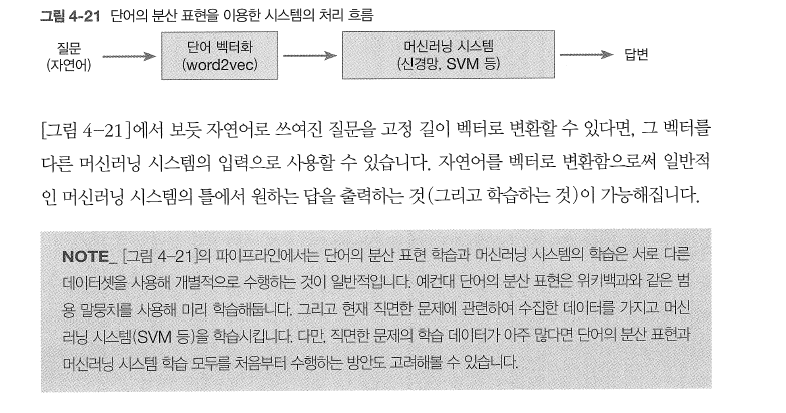

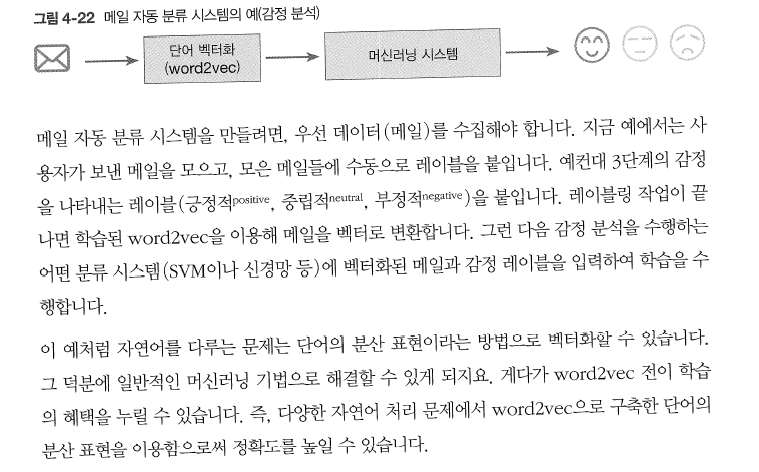

## 4.4.2 단어 벡터 평가 방법

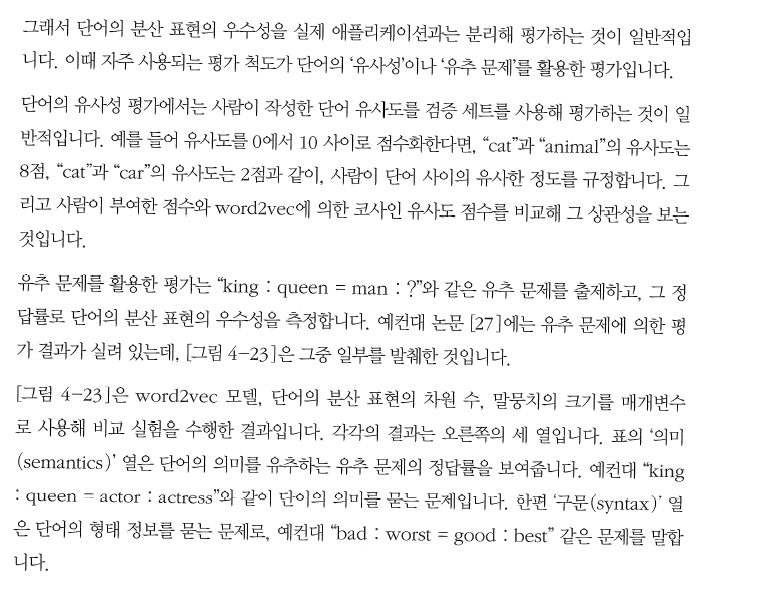

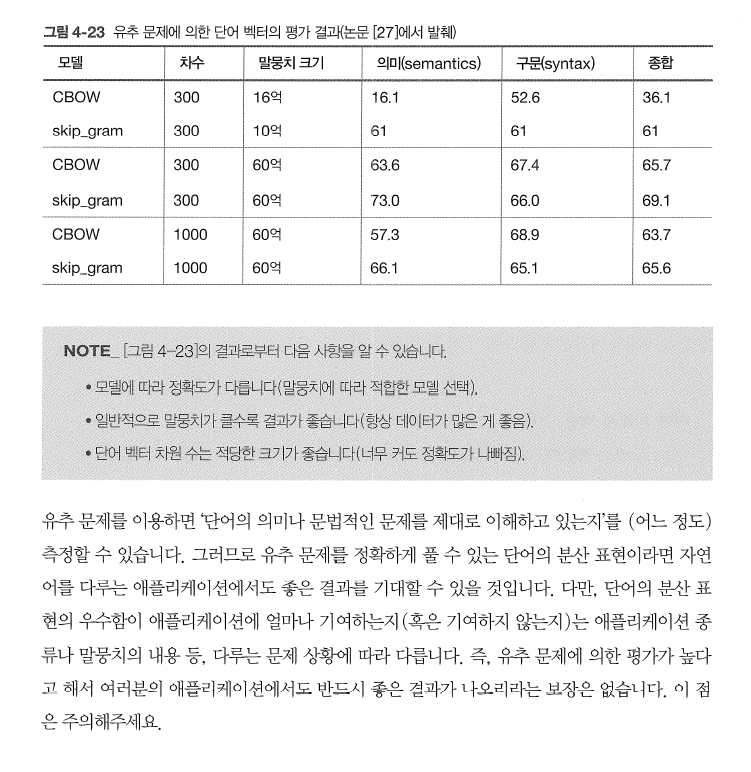

# 4.5 정리

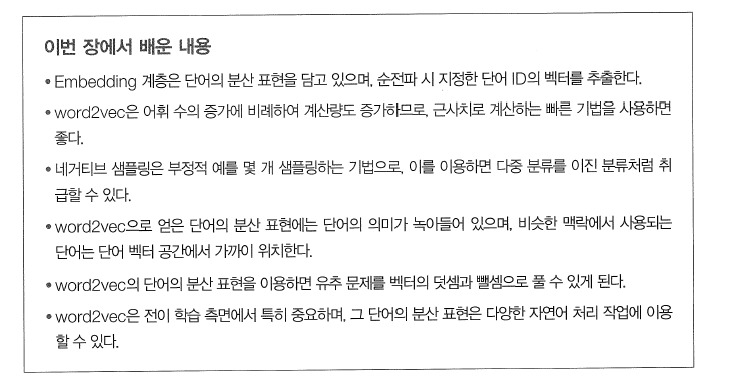